### Setup and imports

In [1]:
import tensorflow as tf
tf.__version__

'2.3.1'

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
import time

from IPython import display

### Preprocessing and data loading

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_ds = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Create discriminator

In [4]:
discriminator = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28, 1)),

    tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
], name='discriminator')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)       

### Create generator

In [5]:
latent_dim = 128

generator = tf.keras.Sequential([
  tf.keras.Input(shape=(latent_dim,)),
    # We want to generate 128 coefficients to reshape into a 7x7x128 map
    layers.Dense(7 * 7 * 128),
    layers.LeakyReLU(alpha=0.2),
    layers.Reshape((7, 7, 128)),
    layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(1, (7, 7), padding="same", activation="tanh"),
], name='generator')
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              809088    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)       0 

### Override the train_step

In [6]:
class GAN(tf.keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  def train_step(self, real_images):
    if isinstance(real_images, tuple):
      real_images = real_images[0]
    # Sample random points in the latent space
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # Decode them to fake images
    generated_images = self.generator(random_latent_vectors)

    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat([
      tf.ones((batch_size, 1)),
      tf.zeros((batch_size, 1))
    ], axis=0)

    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(tf.shape(labels))


    # Train the discriminator
    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_images)
      d_loss = self.loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(
        zip(grads, self.discriminator.trainable_weights)
    )

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((batch_size, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        predictions = self.discriminator(self.generator(random_latent_vectors))
        g_loss = self.loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
    return {"d_loss": d_loss, "g_loss": g_loss}

### Create a callback save images

In [7]:
class GANMonitor(tf.keras.callbacks.Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images = generated_images * 127.5 + 127.5
    generated_images.numpy()

    plt.figure(figsize=(4,4))
    for i in range(self.num_img):
        img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
        plt.subplot(4, 4, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    if not os.path.exists('images'):
      os.makedirs('images')
    plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### Create a callback save model

In [8]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

### Train the end-to-end model

Epoch 1/500
235/235 [==============================] - ETA: 0s - d_loss: 0.4565 - g_loss: 1.7856

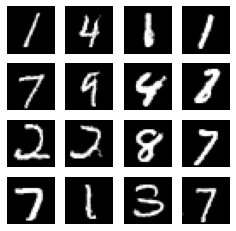


Epoch 00001: saving model to training_1\cp.ckpt
235/235 [==============================] - 19s 82ms/step - d_loss: 0.4564 - g_loss: 1.7855
Epoch 2/500
 24/235 [==>...........................] - ETA: 15s - d_loss: 0.4590 - g_loss: 1.7774

KeyboardInterrupt: 

In [9]:
epochs = 500

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

gan.load_weights(checkpoint_path)

gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0004),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

gan.fit(
    train_ds, epochs=epochs, callbacks=[GANMonitor(num_img=16, latent_dim=latent_dim), cp_callback]
)

### Make GIF

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('images/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)